# Import packages

In [1]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

# Plotting tools
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob
import os

Populating the interactive namespace from numpy and matplotlib


/Users/pradyumna/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


TypeError: consoleWarn() missing 1 required positional argument: 'x'

/Users/pradyumna/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/Users/pradyumna/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/Users/pradyumna/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/Users/pradyumna/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/Users/pradyumna/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 4: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


In [4]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(pbkrtest)
library(broom)
library(dplyr)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(graphics)

## Extra Functions

In [5]:
def CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data_exp1):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_exp1, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_exp1[x_variable]
    y=data_exp1[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title('Like + Dislike Condition')

    results = pearsonr(data_exp1[x_variable], data_exp1[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))


# Load data

In [6]:
data = pd.read_csv('data/FF2018_data/GlamDataFF2018_Like_Bin_v2.csv')
Like_sufix = '_Like_FixBin5_Attempt2'
glam_full_like_estimates = np.load(str('CompareLikeDislike/estimates/glam_FF2018_full_hierarchical_cv'+Like_sufix+'.npy'))   

In [7]:
data.subject

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
3930    32
3931    32
3932    32
3933    32
3934    32
3935    32
3936    32
3937    32
3938    32
3939    32
3940    32
3941    32
3942    32
3943    32
3944    32
3945    32
3946    32
3947    32
3948    32
3949    32
3950    32
3951    32
3952    32
3953    32
3954    32
3955    32
3956    32
3957    32
3958    32
3959    32
Name: subject, Length: 3960, dtype: int64

In [8]:
params_part_like = pd.DataFrame.from_dict(glam_full_like_estimates.item(0))
#glam_full_like_estimates[['gamma']]
params_part_like.gamma

0    -0.45
1    -0.08
2     0.38
3    -0.59
4    -0.61
5    -0.29
6    -0.63
7    -0.48
8    -0.97
9    -0.48
10   -0.33
11   -0.54
12   -0.54
13   -0.23
14    0.03
15   -0.56
16   -0.58
17   -0.53
18   -0.87
19   -0.83
20   -0.86
21   -0.49
22   -0.61
23   -0.63
24   -0.14
25   -0.51
26   -0.95
27   -0.12
28   -0.86
29   -0.92
30   -0.87
31   -0.95
32   -0.66
Name: gamma, dtype: float64

In [9]:
data = data.drop(['Unnamed: 0'], axis=1)

In [10]:
z_matrix=[]
z_matrix_aux=[]

for i in (data['subject'].unique()):
    Choicedata = data.loc[data['subject'] == i]    
    gamma = [params_part_like.gamma[i]]*len(Choicedata)
    abs_evid_0 = Choicedata.gaze_0 * Choicedata.item_value_0 + (1-Choicedata.gaze_0) * Choicedata.item_value_0*gamma
    abs_evid_1 = Choicedata.gaze_1 * Choicedata.item_value_1 + (1-Choicedata.gaze_1) * Choicedata.item_value_1*gamma
    R0_star= abs_evid_0 - abs_evid_1
    R1_star= abs_evid_1 - abs_evid_0
    R0=(R0_star-R0_star.min())/(R0_star.max()-R0_star.min())
    R1=(R1_star-R1_star.min())/(R1_star.max()-R1_star.min())
    
    z_matrix_aux= np.column_stack((gamma,abs_evid_0,abs_evid_1,R0_star,R1_star,R0,R1))
    
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])
    # Add to aggregate table
    
aggregate_trial = np.column_stack((data,z_matrix))
data1 = pd.DataFrame(aggregate_trial,columns=["subject","trial","rt","choice","item_value_0","item_value_1","gaze_0","gaze_1","gamma","abs_evid_0","abs_evid_1","R0_star","R1_star","R0","R1"])

    
data1.head()

,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,gamma,abs_evid_0,abs_evid_1,R0_star,R1_star,R0,R1
0,0.0,0.0,2009.0,0.0,0.0,0.0,0.568396,0.431604,-0.45,0.000000,0.000000,0.000000,0.000000,0.420407,0.579593
1,0.0,1.0,3371.0,0.0,5.0,4.0,0.762332,0.237668,-0.45,3.276906,-0.421525,3.698430,-3.698430,1.000000,0.000000
2,0.0,2.0,1700.0,1.0,0.0,5.0,0.446809,0.553191,-0.45,0.000000,1.760638,-1.760638,1.760638,0.144491,0.855509
3,0.0,3.0,7466.0,1.0,1.0,2.0,0.532352,0.467648,-0.45,0.321911,0.456179,-0.134268,0.134268,0.399365,0.600635
4,0.0,4.0,1889.0,1.0,5.0,5.0,0.529736,0.470264,-0.45,1.590589,1.159411,0.431177,-0.431177,0.487978,0.512022


In [11]:
    
DAbsEvi= data1.abs_evid_1 - data1.abs_evid_0
DR= data1.R1 - data1.R0

DVal = data1.item_value_1 - data1.item_value_0
DGaze = data1.gaze_1 - data1.gaze_0


# Given like condition
# Create column for correct/incorrect 
# 1: correct 2: incorrect 

correct = np.where(data['item_value_1']>=data['item_value_0'], 1, 0)

In [12]:
correct

array([1, 0, 1, ..., 1, 1, 1])

In [13]:
data1["DAbsEvi"] = DAbsEvi
data1["DR"] = DR
data1["DV"] = DVal
data1["AbsDV"] = DVal.abs()
data1["DGaze"] = DGaze
data1["correct"] = correct


In [14]:
data1.loc[data['subject'] == 3].head()

,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,gamma,abs_evid_0,...,R0_star,R1_star,R0,R1,DAbsEvi,DR,DV,AbsDV,DGaze,correct
360,3.0,0.0,3916.0,0.0,0.0,0.0,0.686415,0.313585,-0.59,0.000000,...,0.000000,0.000000,0.493604,0.506396,0.000000,0.012791,0.0,0.0,-0.372829,1
361,3.0,1.0,2427.0,0.0,5.0,2.0,0.726171,0.273829,-0.59,2.823058,...,3.132281,-3.132281,0.870284,0.129716,-3.132281,-0.740568,-3.0,3.0,-0.452342,0
362,3.0,2.0,3746.0,1.0,1.0,1.0,0.421530,0.578470,-0.59,0.080232,...,-0.249535,0.249535,0.463596,0.536404,0.249535,0.072808,0.0,0.0,0.156941,1
363,3.0,3.0,3621.0,0.0,3.0,1.0,0.919054,0.080946,-0.59,2.613885,...,3.075181,-3.075181,0.863417,0.136583,-3.075181,-0.726835,-2.0,2.0,-0.838107,0
364,3.0,4.0,2167.0,1.0,4.0,3.0,0.293122,0.706878,-0.59,-0.495746,...,-2.097556,2.097556,0.241358,0.758642,2.097556,0.517284,-1.0,1.0,0.413757,0


In [15]:
# Calculate Z-values 
z_matrix=[]
z_matrix_aux=[]

for i in (data1['subject'].unique()):
    Choicedata = data1.loc[data['subject'] == i]    
    
    pX_RT = pd.to_numeric(Choicedata["rt"]) 
    pX_zRT = (pX_RT - np.mean(pX_RT))/np.std(pX_RT)

    pX_DAbsEvi = pd.to_numeric(Choicedata["DAbsEvi"]) 
    pX_zDAbsEvi = (pX_DAbsEvi - np.mean(pX_DAbsEvi))/np.std(pX_DAbsEvi)
    
    pX_DR = pd.to_numeric(Choicedata["DR"]) 
    pX_zDR = (pX_DR - np.mean(pX_DR))/np.std(pX_DR)

    pX_DV = pd.to_numeric(Choicedata["DV"]) 
    pX_zDV = (pX_DV - np.mean(pX_DV))/np.std(pX_DV)

    pX_DG = pd.to_numeric(Choicedata["DGaze"]) 
    pX_zDG = (pX_DG - np.mean(pX_DG))/np.std(pX_DG)

    
    z_matrix_aux= np.column_stack((pX_zRT,pX_zDAbsEvi,pX_zDR,pX_zDV,pX_zDG))
    
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])
# Add to aggregate table
aggregate_trial = np.column_stack((data1,z_matrix))
data2 = pd.DataFrame(aggregate_trial,columns=["subject","trial","rt","choice","item_value_0","item_value_1","gaze_0","gaze_1","gamma","abs_evid_0","abs_evid_1","R0_star","R1_star","R0","R1","DA","DR","DV","AbsDV","DG","correct","z_rt","z_DA","z_DR","z_DV","z_DG"])


In [16]:
TotV= data2.item_value_0 + data1.item_value_1
data2["TotV"] = TotV


In [17]:
data2.head()

,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,gamma,abs_evid_0,...,DV,AbsDV,DG,correct,z_rt,z_DA,z_DR,z_DV,z_DG,TotV
0,0.0,0.0,2009.0,0.0,0.0,0.0,0.568396,0.431604,-0.45,0.000000,...,0.0,0.0,-0.136792,1.0,-0.599044,0.109683,0.109683,0.000000,-0.399816,0.0
1,0.0,1.0,3371.0,0.0,5.0,4.0,0.762332,0.237668,-0.45,3.276906,...,-1.0,1.0,-0.524664,0.0,0.289097,-2.587191,-2.587191,-0.360375,-2.127093,9.0
2,0.0,2.0,1700.0,1.0,0.0,5.0,0.446809,0.553191,-0.45,0.000000,...,5.0,5.0,0.106383,1.0,-0.800539,1.393530,1.393530,1.801875,0.683098,5.0
3,0.0,3.0,7466.0,1.0,1.0,2.0,0.532352,0.467648,-0.45,0.321911,...,1.0,1.0,-0.064704,1.0,2.959390,0.207591,0.207591,0.360375,-0.078791,3.0
4,0.0,4.0,1889.0,1.0,5.0,5.0,0.529736,0.470264,-0.45,1.590589,...,0.0,0.0,-0.059473,1.0,-0.677295,-0.204729,-0.204729,0.000000,-0.055494,10.0


## Run Tau transformations

In [18]:
%%R -i data2
datas  <- data2


Like BIC: 4811.294

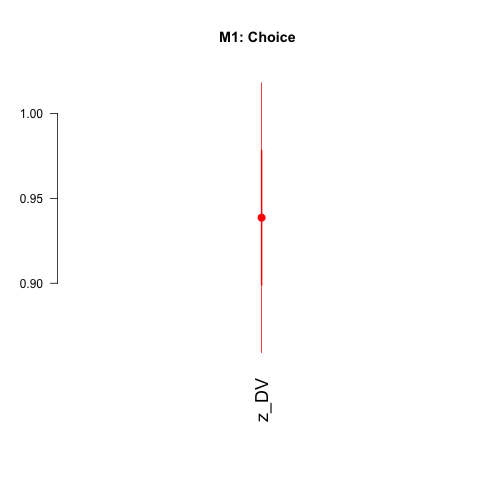

In [19]:
%%R    
title_plot = "M1: Choice  "
ModelChoice_1 <- glm(choice ~ z_DV, data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1 = BIC(ModelChoice_1)
cat("Like BIC:" , BIC1)

Like BIC: 3619.724

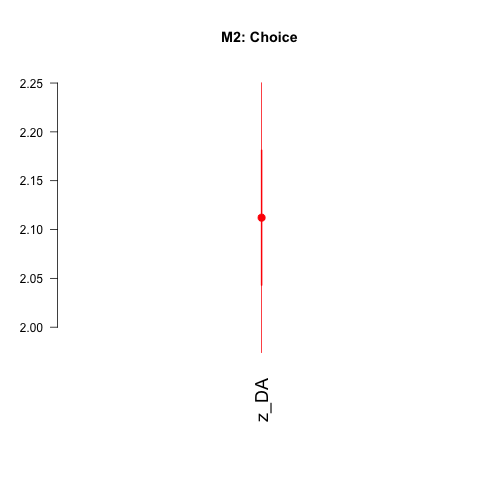

In [20]:
%%R    
title_plot = "M2: Choice "
ModelChoice_2 <- glm(choice ~ z_DA, data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_2,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC2 = BIC(ModelChoice_2)
cat("Like BIC:" , BIC2)

Like BIC: 4063.237

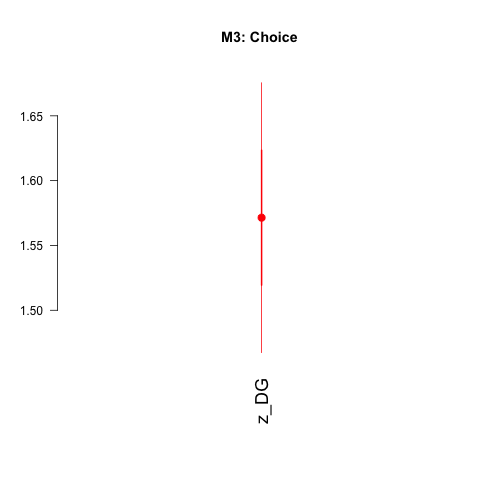

In [21]:
%%R    
title_plot = "M3: Choice "
ModelChoice_3 <- glm(choice ~ z_DG , data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_3,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC3 = BIC(ModelChoice_3)
cat("Like BIC:" , BIC3)

Like BIC: 3619.724

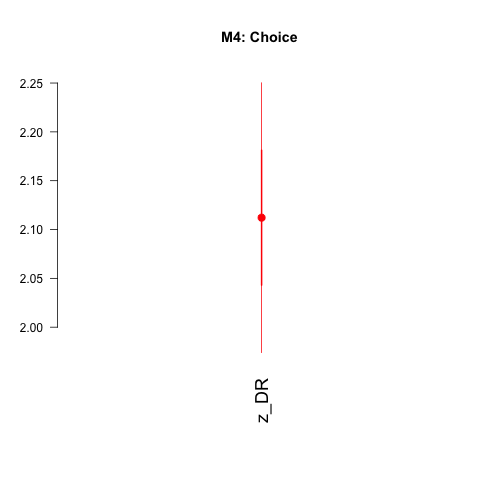

In [22]:
%%R    
title_plot = "M4: Choice "
ModelChoice_4 <- glm(choice ~ z_DR, data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_4,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC4 = BIC(ModelChoice_4)
cat("Like BIC:" , BIC4)

In [23]:
%%R
models  <- rep(c('Choic-DV','Choic-DA','Choic-DG','Choic-DR'))
bics  <- c(BIC1,BIC2,BIC3,BIC4)
BICdf<-data.frame(models,bics)


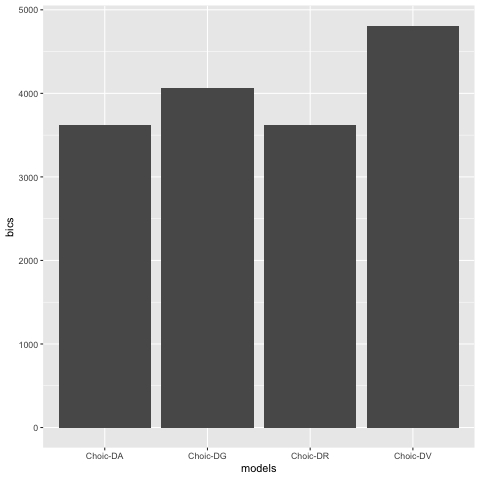

In [24]:
%%R
p <-ggplot(BICdf, aes(models,bics))
p +geom_bar(stat = "identity")

Like BIC: 3546.663

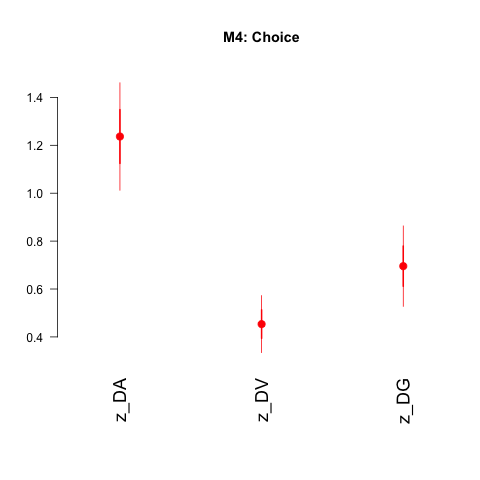

In [25]:
%%R    
title_plot = "M4: Choice"
ModelChoice_e1 <- glm(choice ~ z_DA+ z_DV + z_DG , data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_e1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICe1 = BIC(ModelChoice_e1)
cat("Like BIC:" , BICe1)

How to model the accumulation of evidence?
Do we observe from the data that the RT is dependant on the difference in relative evidence? In this case DV should present an effect over the proportion of correct and incorrect. Is it dependant on the Value of the options (high value --> high evidence)? In this case we should answer better when the value of items is higher.

Like BIC: 4929.968
Call:  glm(formula = correct ~ rt + AbsDV + TotV, family = binomial(link = "logit"), 
    data = datas)

Coefficients:
(Intercept)           rt        AbsDV         TotV  
  1.481e+00   -3.175e-05   -4.240e-01   -2.074e-02  

Degrees of Freedom: 3959 Total (i.e. Null);  3956 Residual
Null Deviance:	    5260 
Residual Deviance: 4897 	AIC: 4905


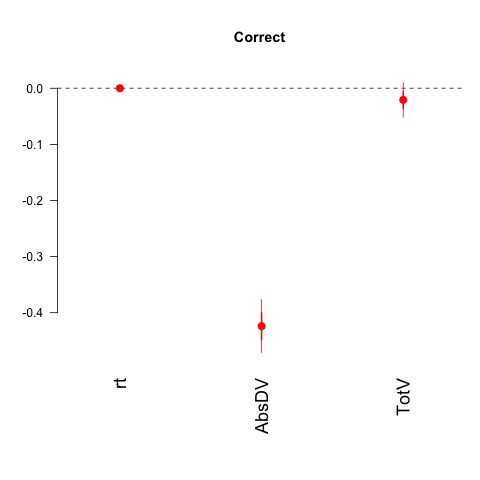

In [26]:
%%R
title_plot = " Correct  "
ModelCorrect_1 <- glm(correct ~ rt + AbsDV +TotV, data= datas, family=binomial(link="logit"))
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("Like BIC:" , BICc1)
ModelCorrect_1

Pearson's r = 0.005 p =  0.774
Pearson's r = -0.299 p =  0.0
Pearson's r = -0.051 p =  0.001


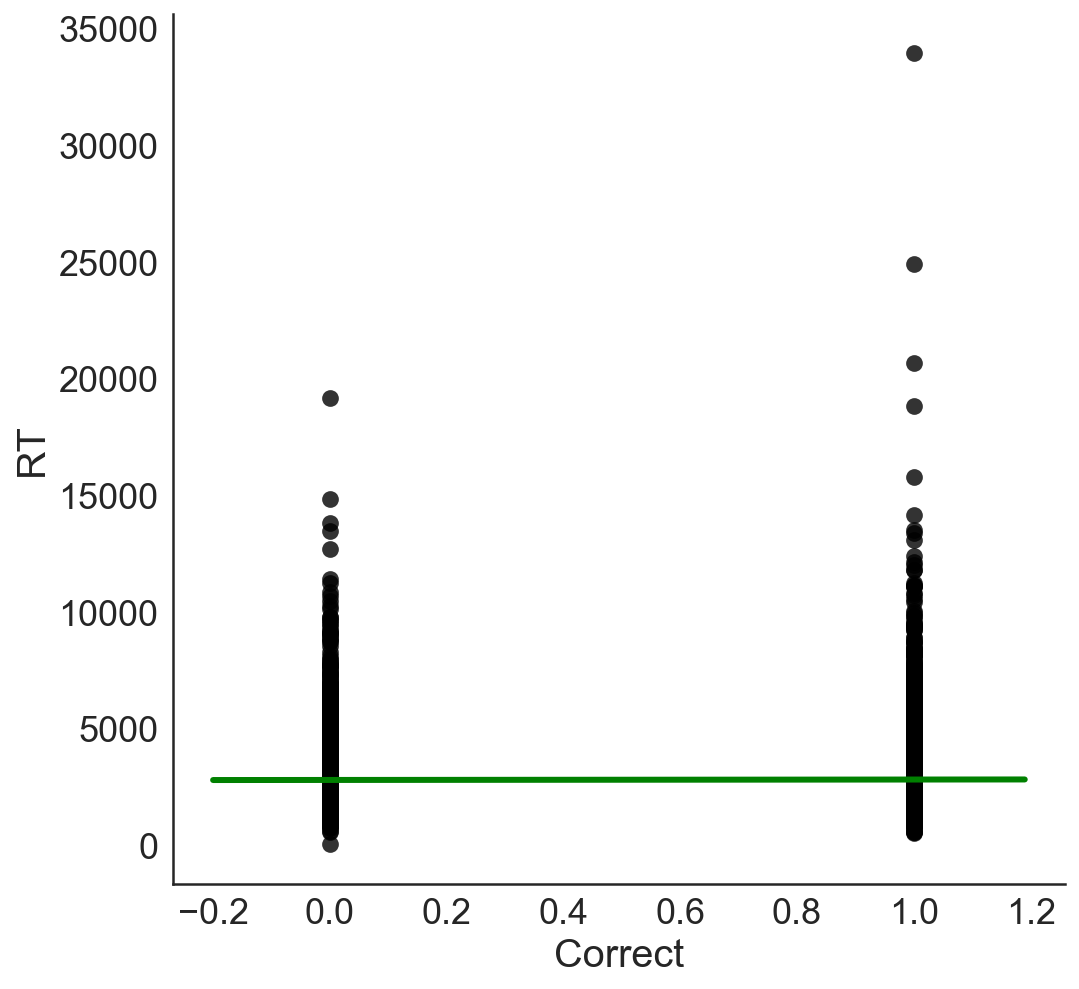

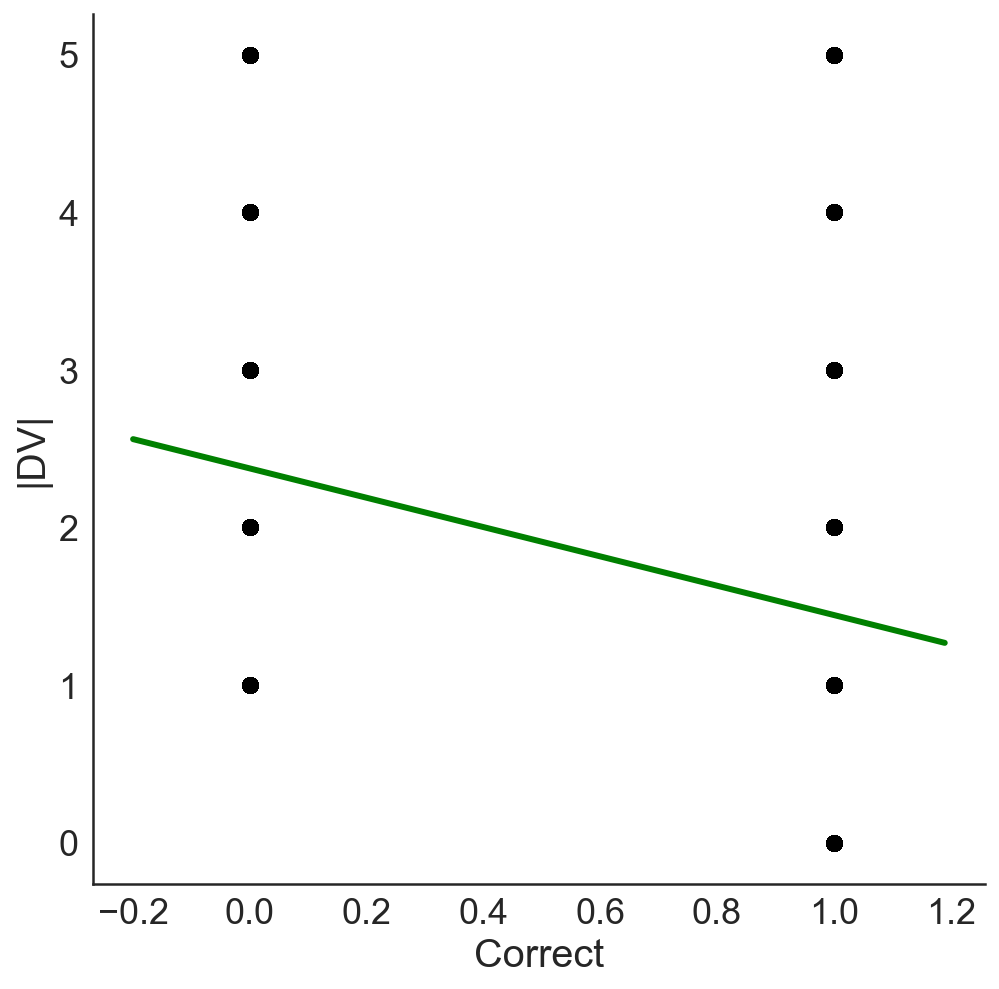

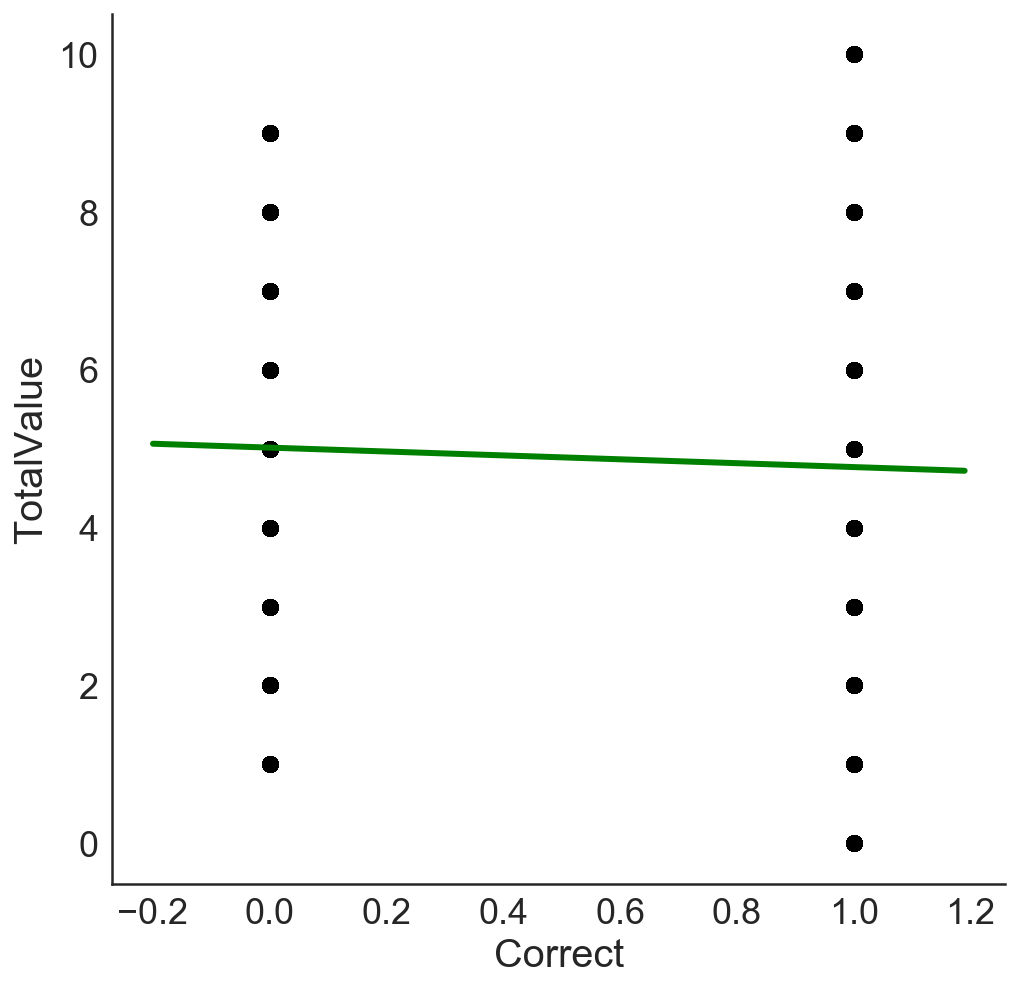

In [27]:
x_variable = 'correct'
x_varlabel = 'Correct'
y_variable = 'rt'
y_varlabel =  'RT'
CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data2)

x_variable = 'correct'
x_varlabel = 'Correct'
y_variable = 'AbsDV'
y_varlabel =  '|DV|'
CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data2)

x_variable = 'correct'
x_varlabel = 'Correct'
y_variable = 'TotV'
y_varlabel =  'TotalValue'
CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data2)


Looks like if we try to predict rt, DV has an effect, making faster responses when there are bigger differences between the items. In the case of TotValue, looks like when the items are more valuable the decision take more time. This looks oposed to the models of accumulation of evidence that Marius proposed.

Like BIC: 71085.18
Call:  glm(formula = rt ~ correct + AbsDV + TotV + correct:AbsDV, data = datas)

Coefficients:
  (Intercept)        correct          AbsDV           TotV  correct:AbsDV  
      3118.68        -253.45        -196.26          31.83          66.94  

Degrees of Freedom: 3959 Total (i.e. Null);  3955 Residual
Null Deviance:	    1.452e+10 
Residual Deviance: 1.431e+10 	AIC: 71050


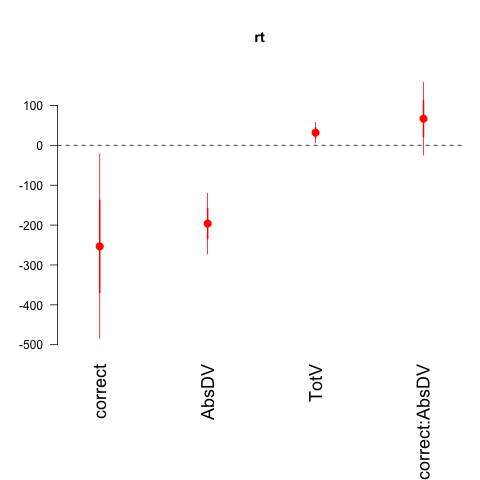

In [59]:
%%R
title_plot = " rt  "
ModelCorrect_1 <- glm(rt ~ correct + AbsDV +TotV + correct:AbsDV,  data= datas)
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("Like BIC:" , BICc1)
ModelCorrect_1

Pearson's r = -0.105 p =  0.0
Pearson's r = 0.029 p =  0.068


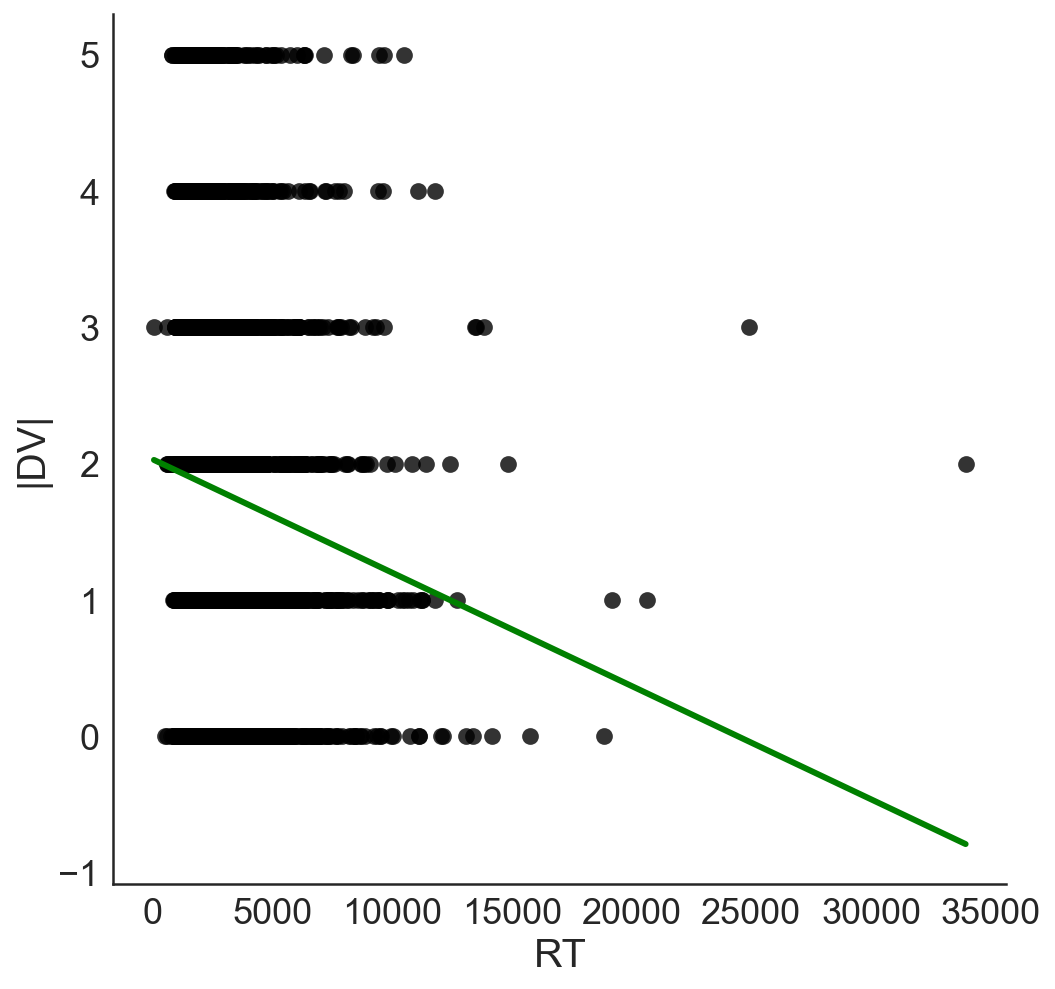

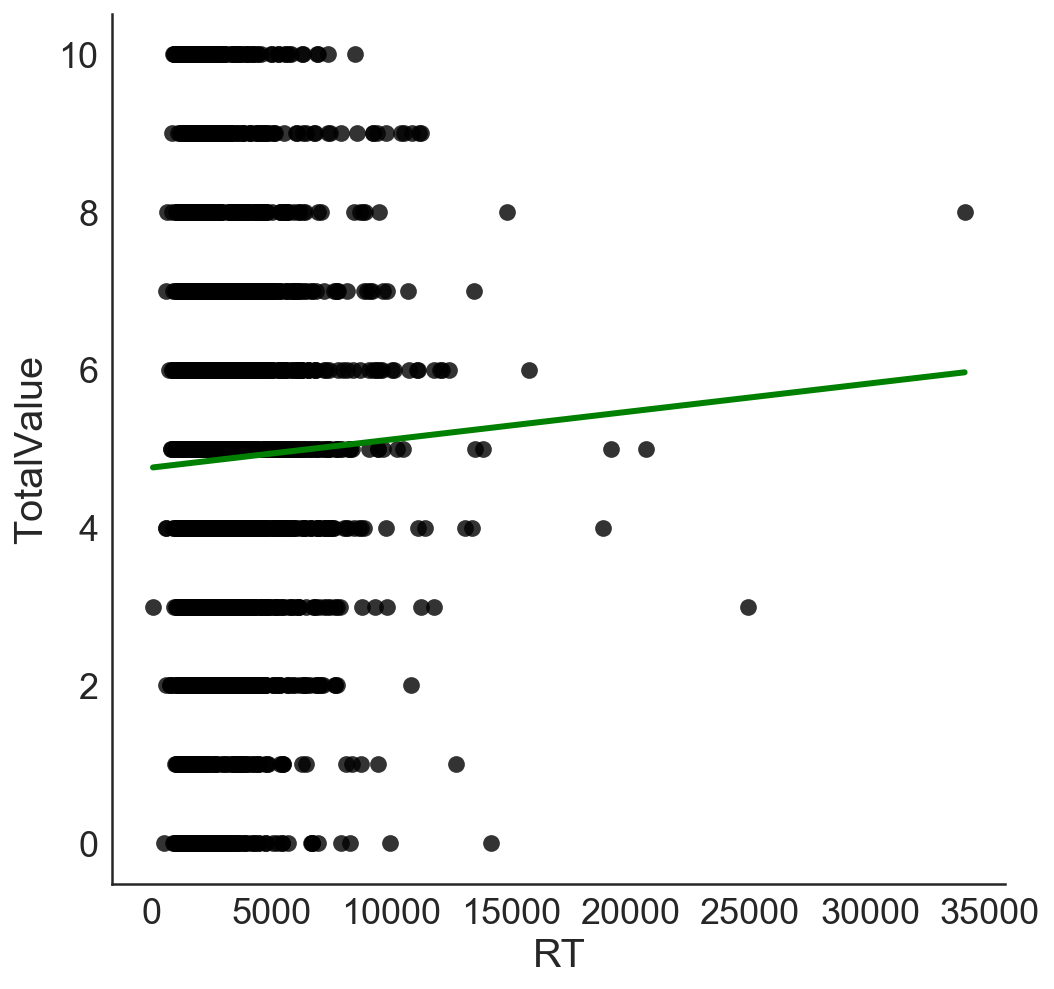

In [29]:
x_variable = 'rt'
x_varlabel =  'RT'
y_variable = 'AbsDV'
y_varlabel =  '|DV|'
CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data2)

x_variable = 'rt'
x_varlabel =  'RT'
y_variable = 'TotV'
y_varlabel =  'TotalValue'
CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data2)


## Extra Functions

In [30]:
def CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data_exp1):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_exp1, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_exp1[x_variable]
    y=data_exp1[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title('Like + Dislike Condition')

    results = pearsonr(data_exp1[x_variable], data_exp1[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))


# Accumulator model

In [31]:
## Load fixation sequence
data_fix = pd.read_csv('data/FF2018_data/fixations_seq_Like.csv')

In [32]:
data_fix.head()

,parcode,trial,fix_item,fix_time
0,0,0,3,313
1,0,0,1,258
2,0,0,1,294
3,0,0,2,342
4,0,0,2,286


In [33]:
# We wont consider accumulation of evidence in the case the participant doesn't observe the IA

In [34]:
IAFixMatrix = []

for i in (data_fix['parcode'].unique()):
    PartIAFixMatrix= data_fix.loc[(data_fix['parcode'] == i )]
    trialNums = pd.unique(PartIAFixMatrix["trial"])
    for j in trialNums:
        
        PartTrialIAFixMatrix= PartIAFixMatrix.loc[(PartIAFixMatrix['trial'] == j )]
        # considering that IA 1 is left and IA 2 is right ( IAs 3 and 0 are not fixated in the item)
        # I won't consider time in this case
        FixSequence = PartTrialIAFixMatrix.loc[(PartTrialIAFixMatrix['fix_item'] != 0) & (PartTrialIAFixMatrix['fix_item'] != 3), 'fix_item']
        FixSequence = FixSequence.values
        #LGazeTime = PartTrialIAFixMatrix.loc[PartTrialIAFixMatrix['fix_item'] == 1, 'fix_time'].sum() 
        ## Sum right item
        #RGazeTime = PartTrialIAFixMatrix.loc[PartTrialIAFixMatrix['fix_item'] == 2, 'fix_time'].sum()  
        #LGaze = LGazeTime/(LGazeTime + RGazeTime)
        #RGaze = RGazeTime/(LGazeTime + RGazeTime)
        
        IAFixMatrix.append(FixSequence) 

In [35]:
len(IAFixMatrix)

3960

In [36]:
# Add to aggregate dataframe
aggregate_trial = np.column_stack((data2,IAFixMatrix))
data3 = pd.DataFrame(aggregate_trial,columns=["subject","trial","rt","choice","item_value_0","item_value_1","gaze_0","gaze_1","gamma","abs_evid_0","abs_evid_1","R0_star","R1_star","R0","R1","DA","DR","DV","AbsDV","DG","correct","z_rt","z_DA","z_DR","z_DV","z_DG","TotV","fix_seq"])


In [57]:
data3.fix_seq[3]
data3.head()

,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,gamma,abs_evid_0,...,AbsDV,DG,correct,z_rt,z_DA,z_DR,z_DV,z_DG,TotV,fix_seq
0,0,0,2009,0,0,0,0.568396,0.431604,-0.45,0,...,0,-0.136792,1,-0.599044,0.109683,0.109683,0,-0.399816,0,"[1, 1, 2, 2, 2, 1]"
1,0,1,3371,0,5,4,0.762332,0.237668,-0.45,3.27691,...,1,-0.524664,0,0.289097,-2.58719,-2.58719,-0.360375,-2.12709,9,"[1, 1, 1, 2, 2, 1, 1, 1, 1, 1]"
2,0,2,1700,1,0,5,0.446809,0.553191,-0.45,0,...,5,0.106383,1,-0.800539,1.39353,1.39353,1.80187,0.683098,5,"[1, 1, 1, 2, 2]"
3,0,3,7466,1,1,2,0.532352,0.467648,-0.45,0.321911,...,1,-0.0647042,1,2.95939,0.207591,0.207591,0.360375,-0.0787912,3,"[1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, ..."
4,0,4,1889,1,5,5,0.529736,0.470264,-0.45,1.59059,...,0,-0.0594727,1,-0.677295,-0.204729,-0.204729,0,-0.055494,10,"[1, 1, 1, 1, 2, 2]"


# Let's give some value to the paramters in the simulations

The equations for the accumulators are 

$x_{L}$(t+1) = $\lambda$$x_{L}$(t) + $\beta$$I_{L}$




$x_{R}$(t+1) = $\lambda$$x_{R}$(t) + $\beta$$I_{R}$

$I_{L}$ and $I_{R}$: works as unit ot be accumulated during each time point (in this case each fixation). If participant is not fixing the item, they accumulate half evidence for that item. Evidence unit available to be accumulated will be the value of the item indicated by item_value_0 and item_value_1, respectively.

In [ ]:
lambda = 1

In [38]:
# initialize accumulators vectors. We will generate an accumulator vector for right and left options
# for each trial

x_L = []
x_R = []

for i in (data3['subject'].unique()):
    SubjectMatrix= data3.loc[(data3['subject'] == i )]
    trialNums = pd.unique(PartIAFixMatrix["trial"])
    for j in trialNums:
        TrialMatrix= SubjectMatrix.loc[(SubjectMatrix['trial'] == j )]
        FixSeq = TrialMatrix.fix_seq.values[0]
        for k in range(len(FixSeq)):
            if FixSeq[k] == 0 # if fixation is item left (0)
                x_L_now = x_L[-1] +   
            

        

SyntaxError: unexpected EOF while parsing (<ipython-input-38-f55ca0492631>, line 16)